<a href="https://colab.research.google.com/github/govind527/Pytorch_Practice/blob/main/pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
## importing libraries

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms

from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torchvision.__version__)

0.21.0+cu124


In [4]:
train_data=datasets.FashionMNIST(
    root="data",# where to download the data
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(), ## how we want to transform data
    target_transform =None ## wnat to transform labels
)

test_data=datasets.FashionMNIST(
    root="data", # where to download the data
    train=False,
    download=True,
    transform=ToTensor(), ## how we want to transform data
    target_transform =None ## wnat to transform labels
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.9MB/s]


In [5]:
len(train_data),len(test_data)

(60000, 10000)

In [6]:
## first training example
image,label=train_data[0]
image,label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [7]:
image.shape,label

(torch.Size([1, 28, 28]), 9)

In [8]:
class_names=train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
class_to_id=train_data.class_to_idx
class_to_id

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [10]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

## visualizing data

torch.Size([1, 28, 28])


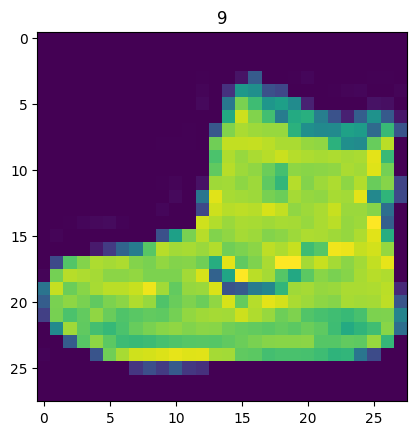

In [11]:
import matplotlib.pyplot as plt
image,label=train_data[0]
print(image.shape)
plt.imshow(image.squeeze())
plt.title(label);

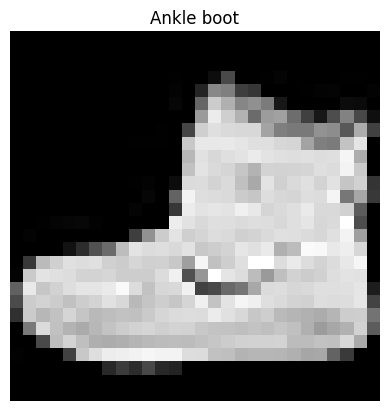

In [12]:
plt.imshow(image.squeeze(),cmap="gray")
plt.title(train_data.classes[label])
plt.axis(False);

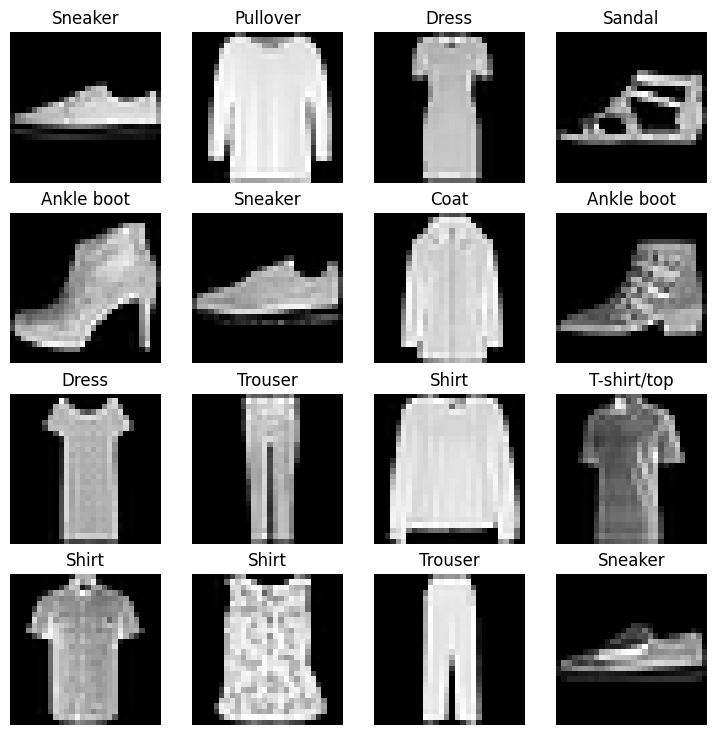

In [13]:
##torch.manual_seed(42)
fig=plt.figure(figsize=(9,9))
rows,cols=4,4
for i in range(1,rows*cols+1):
  random_idx=torch.randint(0,len(train_data),size=[1]).item()
  img,label=train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(train_data.classes[label])
  plt.axis(False);

## dataloader preparation

In [14]:
train_data,test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [15]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7aea505378d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7aea5288d910>)

In [16]:
print(f"train Dataloader : {train_dataloader}")
print(f"train Dataloader length : {len(train_dataloader)} of batches {BATCH_SIZE}")
print(f"test Dataloader length : {len(test_dataloader)} of batches {BATCH_SIZE}")

train Dataloader : <torch.utils.data.dataloader.DataLoader object at 0x7aea505378d0>
train Dataloader length : 1875 of batches 32
test Dataloader length : 313 of batches 32


In [17]:
train_features_batch,train_label_batch=next(iter(train_dataloader))

train_features_batch.shape

torch.Size([32, 1, 28, 28])

image size: torch.Size([1, 28, 28])
label : 1 || label size: torch.Size([])


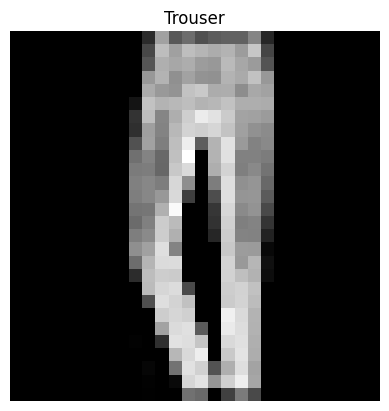

In [18]:
torch.manual_seed(42)
random_idx=torch.randint(0,len(train_features_batch),size=[1]).item()
img,label=train_features_batch[random_idx],train_label_batch[random_idx]
plt.imshow(img.squeeze(),cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"image size: {img.shape}")
print(f"label : {label} || label size: {label.shape}")

## building first baseline model for cv

In [19]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int
               ):
    super().__init__()
    self.layer_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),

    )

  def forward(self,x):
    return self.layer_stack(x)

In [20]:
torch.manual_seed(42)
model_0=FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [21]:
dummy_x=torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [22]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

In [23]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper function already exist skip downloading...")
else:
  print("downloading helper function")
  request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open('helper_functions.py','wb') as f:
    f.write(request.content)

downloading helper function


In [24]:
from helper_functions import accuracy_fn

## setup loss function and optimizer
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)

In [25]:
## creating a funtion to get time of our experiments

from timeit import default_timer as timer

def print_train_time(start:float,
                     end:float,
                     device:torch.device=None):
  total_time=end-start
  print(f"train timr on {device} : {total_time:.3f} seconds")
  return total_time

In [26]:
from tqdm.auto import tqdm ## to see progress bar

torch.manual_seed(42)
train_time_start_on_cpu=timer()

epochs=3 ## small for faster training time

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n----")
  ## training

  train_loss=0
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()

    ## forward pass
    y_pred=model_0(X)

    ## calculate loss

    loss=loss_fn(y_pred,y)
    train_loss+=loss
    ##3. optimizer zero grad

    optimizer.zero_grad()

    ## backward
    loss.backward()

    ##optimizer step

    optimizer.step()

    if batch% 400==0:
      print(f"looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples.")
  train_loss/=len(train_dataloader)


  ##testing

  test_loss,test_acc=0,0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred=model_0(X_test)

      test_loss+=loss_fn(test_pred,y_test)

      test_acc+=accuracy_fn(y_true=y_test,y_pred=test_pred.argmax(dim=1))

    test_loss/=len(test_dataloader)

    test_acc/=len(test_dataloader)
  print(f"\n Train loss: {train_loss:.4f} | test loss : {test_loss:.4f}, test accuracy : {test_acc:.4f}")

train_time_end_on_cpu=timer()
tottal_train_time_model_0=print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
----
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.

 Train loss: 0.5904 | test loss : 0.5095, test accuracy : 82.0387
Epoch: 1 
----
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.

 Train loss: 0.4763 | test loss : 0.4799, test accuracy : 83.1969
Epoch: 2 
----
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.

 Train loss: 0.4550 | test loss : 0.4766, test accuracy : 83.4265
train timr on cpu : 25.025 seconds


In [27]:
str(next(model_0.parameters()).device)

'cpu'

## making predictions and model results

In [48]:
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
  loss,acc=0,0
  model_0.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      ##X,y=X.to(device),y.to(device)
      y_pred=model(X)

      loss+=loss_fn(y_pred,y)
      acc+=accuracy_fn(y_true=y,
                       y_pred=y_pred.argmax(dim=1))

    loss/=len(data_loader)
    acc/=len(data_loader)

  return {"model name" : model.__class__.__name__,
          "model loss" : loss.item(),
          "model acc" : acc}

model_0_results=eval_model(model=model_0,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn)

model_0_results



{'model name': 'FashionMNISTModelV0',
 'model loss': 0.47663888335227966,
 'model acc': 83.42651757188499}

In [29]:
import torch
device ='cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    self.stack_layer=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )
  def forward(self,x:torch.Tensor):
    return self.stack_layer(x)

In [32]:
torch.manual_seed(42)
model_1=FashionMNISTModelV1(input_shape=784,
                            hidden_units=10,
                            output_shape=len(class_names)).to(device)
model_1

FashionMNISTModelV1(
  (stack_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [34]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [37]:
from helper_functions import accuracy_fn

loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.1)

## writing functionthe for train and test code

In [40]:

def train_step(model:nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device=device):



  ## training
  model.train()
  train_loss, train_acc=0,0
  for batch, (X,y) in enumerate(data_loader):
    X=X.to(device)
    y=y.to(device)

    ## forward pass
    y_pred=model(X)

    ## calculate loss

    loss=loss_fn(y_pred,y)
    train_loss+=loss

    train_acc+=accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
    ##3. optimizer zero grad

    optimizer.zero_grad()

    ## backward
    loss.backward()

    ##optimizer step

    optimizer.step()


  train_loss/=len(data_loader)
  train_acc/=len(data_loader)
  print(f"train loss : {train_loss:.5f} | train acc : {train_acc:.2f}%")


In [41]:

def test_step(model:nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device=device):



  ## test
  model.eval()
  test_loss, test_acc=0,0
  with torch.inference_mode():
    for X,y in data_loader:
      X,y=X.to(device),y.to(device)

      test_pred=model(X)
      test_loss+=loss_fn(test_pred,y)
      test_acc+=accuracy_fn(y_true=y,
                            y_pred=test_pred.argmax(dim=1))

    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

    print(f"test loss : {test_loss:.5f} | test acc : {test_acc:.2f}%")

In [44]:
torch.manual_seed(42)

from timeit import default_timer as timer

train_time_start_on_gpu=timer()
epochs=3

for epoch in tqdm(range(epochs)):
  print(f"epoch {epoch} \n ====")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  train_step(model=model_1,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

train_time_end_on_gpu=timer()

total_train_time_model_1=print_train_time(start=train_time_start_on_gpu,
                                          end=train_time_end_on_gpu,
                                          device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 0 
 ====
train loss : 1.09199 | train acc : 61.34%
train loss : 0.98377 | train acc : 63.92%
epoch 1 
 ====
train loss : 0.76874 | train acc : 72.42%
train loss : 0.70073 | train acc : 74.35%
epoch 2 
 ====
train loss : 0.66060 | train acc : 76.23%
train loss : 0.67025 | train acc : 75.25%
train timr on cuda : 29.103 seconds


In [49]:
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn,
               device=device):
  loss,acc=0,0
  model_0.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y=X.to(device),y.to(device)
      y_pred=model(X)

      loss+=loss_fn(y_pred,y)
      acc+=accuracy_fn(y_true=y,
                       y_pred=y_pred.argmax(dim=1))

    loss/=len(data_loader)
    acc/=len(data_loader)

  return {"model name" : model.__class__.__name__,
          "model loss" : loss.item(),
          "model acc" : acc}


In [51]:
model_1_results=eval_model(model=model_1,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn,
                           device=device)
model_1_results

{'model name': 'FashionMNISTModelV1',
 'model loss': 0.7267524003982544,
 'model acc': 71.18610223642173}

In [52]:
model_0_results

{'model name': 'FashionMNISTModelV0',
 'model loss': 0.47663888335227966,
 'model acc': 83.42651757188499}